In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy

import apoc
import pyclesperanto_prototype as cle
import napari
import tifffile

C:\Users\naly008c\.conda\envs\axolotl\Lib\site-packages\pytools\persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
from image_analysis.read_files import get_paths, change_paths
from image_analysis.preprocess import mask
from image_analysis.fit import roi

# GPU device

In [3]:
device = cle.get_device()
print("Device name:", device.name)

Device name: Intel(R) UHD Graphics 620


# Information about the image

In [4]:
channels = {
            "fgf":    0, 
            "shh":    1, 
            "bright": 2, 
            "dapi":   3, 
            "dusp":   4, 
            "auto":   5
           }

# Voxel size
pixel_size_x, pixel_size_y, pixel_size_z = 2*0.9019, 2*0.9019, 2*3.9991

# Fixed values for image preprocessing

In [5]:
downsample = 1                 # downsampling level while image loading (the same along all axis)
pixel_size_aim_user_def = 8e-6 # pixel size for binning
sigma = 1.25                      # for gauss filter before thresholding

# Load image

In [6]:
image_folder_tif = r'example_raw_images/'
sample = '2_5cm_6dpa_noif'

img_paths = get_paths(image_folder_tif, channel='6d',suffix='tif')
img_paths = change_paths(img_paths, include='noif')

In [7]:
img_paths = sorted(
    img_paths,
    key = lambda c: c.split('/c')[1].split('_')[0]
)

In [8]:
img_paths

['example_raw_images/c1_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c2_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c3_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c4_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c5_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c6_hcr21_20240722_6d_noif.tif']

In [9]:
img = []
for path in img_paths:
    i = tifffile.imread(path)
    img.append(i[::downsample, ::downsample, ::downsample])
img = np.array(img).astype( np.uint16 )

channels = list(channels.keys())
img = dict(zip(channels, img))

In [10]:
del img['dapi']
del img['bright']

In [11]:
for key in img.keys():
    img[key] = np.flip(img[key], 2)
    # take 2d slice
    mid_slice = img[key].shape[0] // 2
    img[key] = img[key][mid_slice]

# Plot channels

In [12]:
pixel_size_x, pixel_size_y = downsample*pixel_size_x, downsample*pixel_size_y

In [13]:
height, width = img['dusp'].shape
extent = [0, width * pixel_size_x, height * pixel_size_y, 0]  # Flip y-axis to keep origin at top-left

In [14]:
import matplotlib.cm as cm
import matplotlib
import matplotlib.colors as mcolors

def modified_cmap(base_cmap_name):
    cmap = matplotlib.colormaps[base_cmap_name]
    new_cmap = cmap(np.linspace(0, 1, 256))
    new_cmap[0] = [1, 1, 1, 1]  # Force zero to be white (RGBA)
    return mcolors.ListedColormap(new_cmap)

# Define modified color maps
color_map = {
    'fgf': modified_cmap('Blues'),
    'shh': modified_cmap('Reds'),
    'dusp': modified_cmap('Purples'),
    'tissue_mask': modified_cmap('Greys'),  # Notice the correct spelling for matplotlib
}

In [16]:
del img['auto']

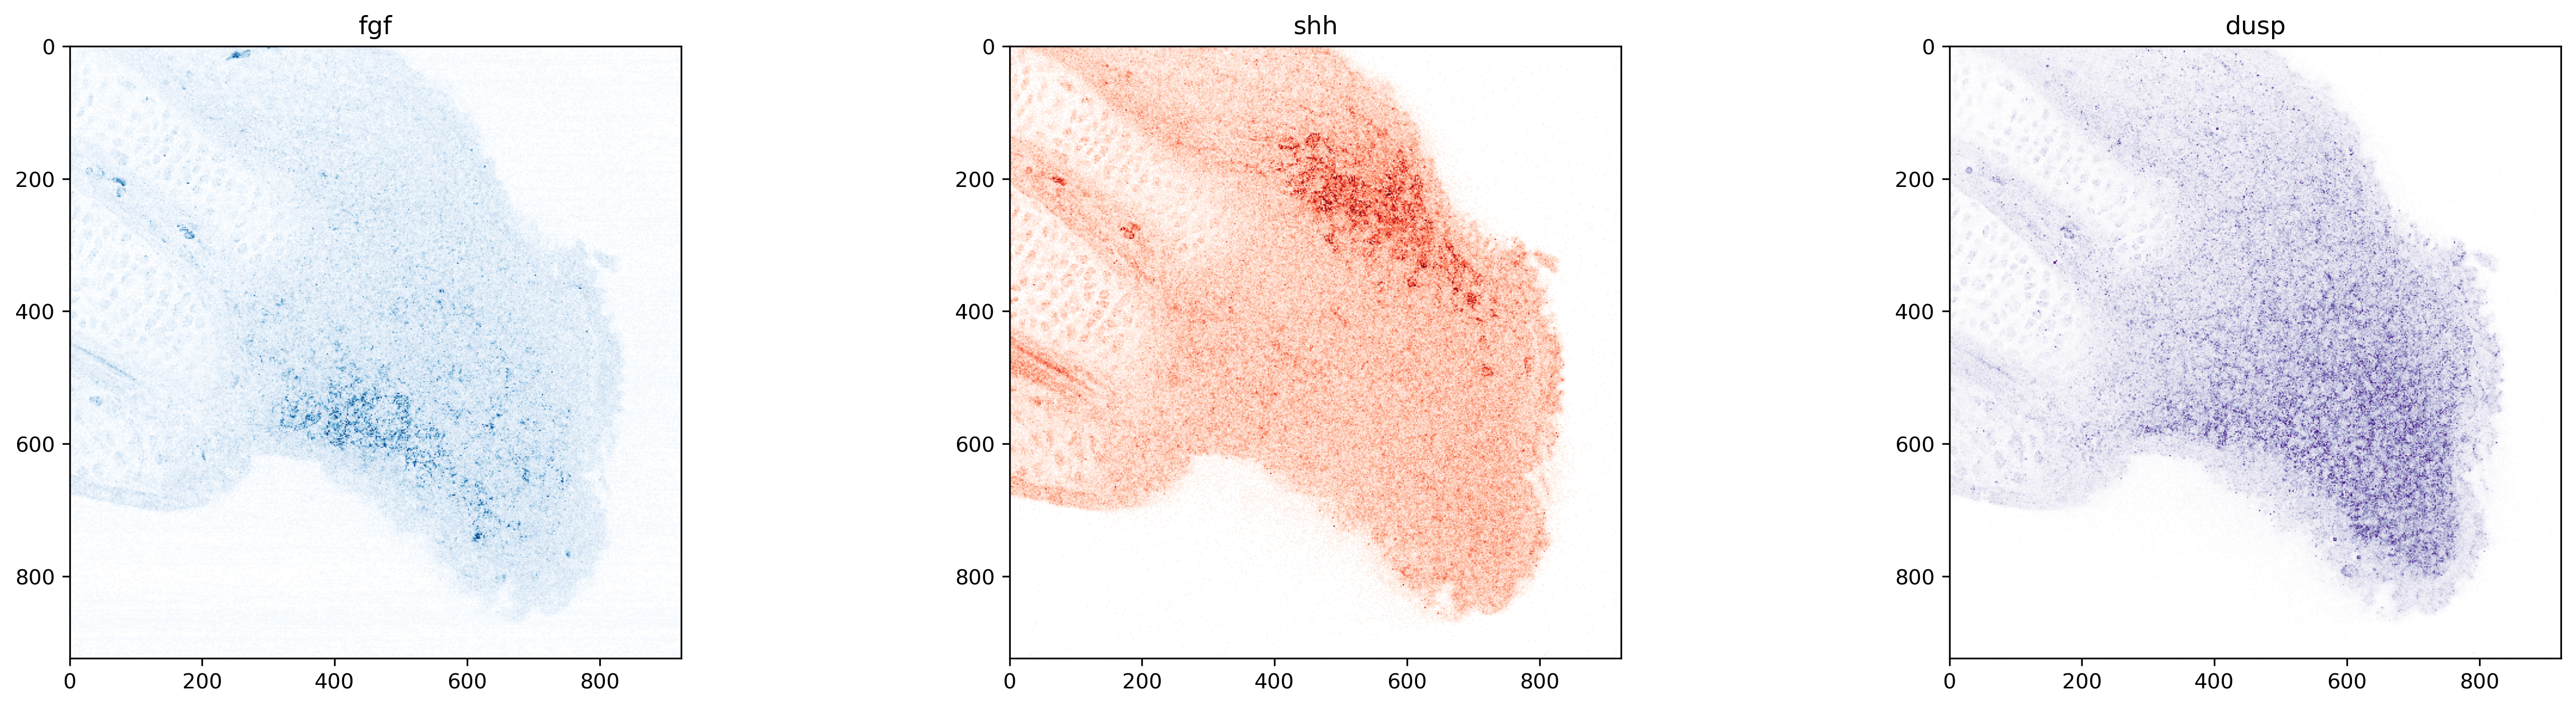

In [17]:
# Plotting
default_figsize = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, len(img), figsize=(default_figsize[0] * len(img), default_figsize[1]), dpi=300)

if len(img) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, (key, image) in zip(axes, img.items()):
    ax.imshow(2*image, cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(key)
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('fig/channels.pdf')
plt.show()